In [618]:
#import the required libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
#importing the libs for the additive and multiplicative decompositions 
from pylab import rcParams
import statsmodels.api as sm
#importing the libs for Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#importing ADF and KPSS libs
from statsmodels.tsa.stattools import adfuller,kpss
#importing boxcox libs
from scipy.stats import boxcox
#importing the ARIMA lib
from statsmodels.tsa.arima_model import ARIMA
#imoporting the acf and pacf libs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#importing SARIMA lib
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.metrics import mean_squared_error
import warnings 
warnings.filterwarnings('ignore')

# Step 1: Viewing and understanding the data

In [619]:
df=pd.read_csv('Global+Superstore+Data.csv')
df.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [620]:
#Checking the shape of the dataset
df.shape

(51290, 5)

In [621]:
#Checking the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [622]:
#Checking for missing values
df.isnull().sum()

Order Date    0
Segment       0
Market        0
Sales         0
Profit        0
dtype: int64

# STEP 2: Data Preparation

In [623]:
#Combining the Market and Segment Columns in to one
df['Market_Segment']= df['Market']+'_' +df['Segment']
df.head()

,Order Date,Segment,Market,Sales,Profit,Market_Segment
0,31-07-2012,Consumer,US,2309.650,762.1845,US_Consumer
1,05-02-2013,Corporate,APAC,3709.395,-288.7650,APAC_Corporate
2,17-10-2013,Consumer,APAC,5175.171,919.9710,APAC_Consumer
3,28-01-2013,Home Office,EU,2892.510,-96.5400,EU_Home Office
4,05-11-2013,Consumer,Africa,2832.960,311.5200,Africa_Consumer


In [624]:
#Viewing the unique values
#As noticed there are 7 different Market Segments and 3 different Customer segements
df.nunique().sort_values()

Segment               3
Market                7
Market_Segment       21
Order Date         1430
Sales             22995
Profit            24575
dtype: int64

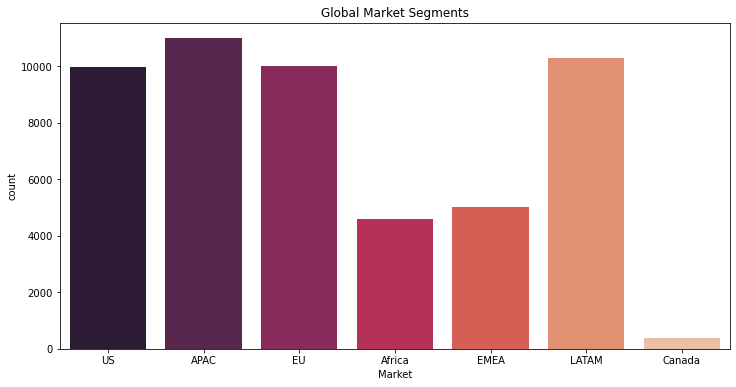

In [625]:
#Viewing the 7 Market segments
plt.figure(figsize=[12,6])
sns.countplot(df['Market'],palette='rocket')
plt.title('Global Market Segments')
plt.show()

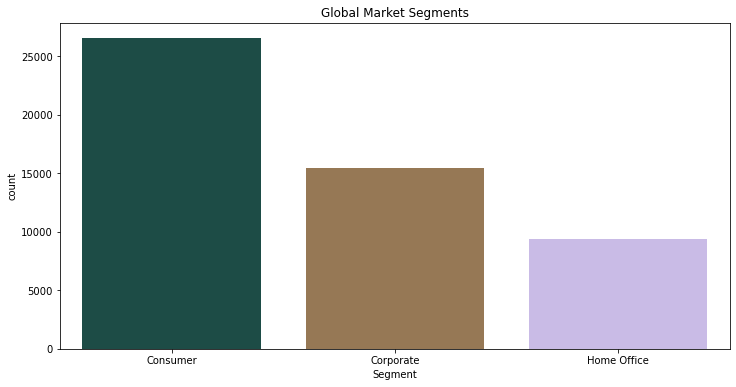

In [626]:
#Viewing the 3 Customer segments 
plt.figure(figsize=[12,6])
sns.countplot(df['Segment'],palette='cubehelix')
plt.title('Global Market Segments')
plt.show()

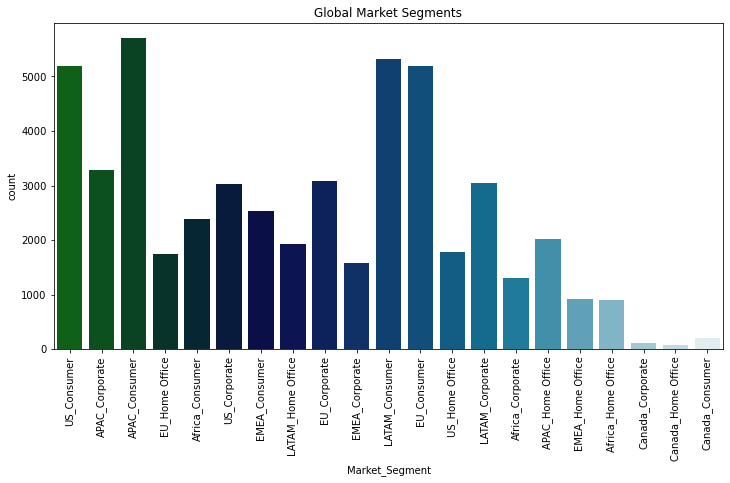

In [627]:
#Viewing the 21 Market and Customer segments 
plt.figure(figsize=[12,6])
sns.countplot(df['Market_Segment'],palette='ocean')
plt.xticks(rotation=90,)
plt.title('Global Market Segments')
plt.show()

#### We can see from the plot APAC_Consumer has the highest count

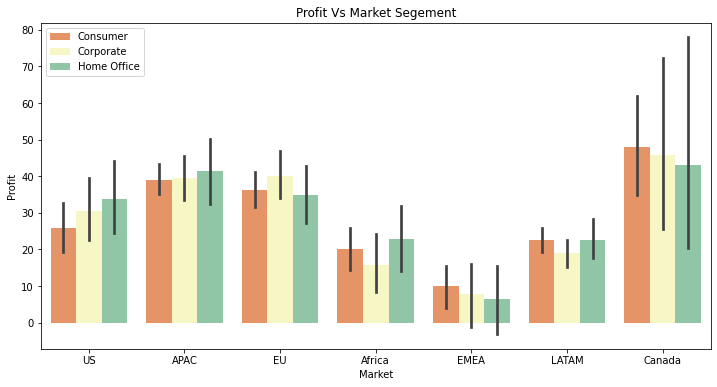

In [628]:
#Plotting the Market segments vs the Profits
plt.figure(figsize=[12,6])
sns.barplot(data=df,x='Market',y='Profit',hue='Segment',palette='Spectral')
plt.title('Profit Vs Market Segement')
plt.legend(loc='best')
plt.show()

#### We can see that Canada and APAC markets with the segments Consumer, Corporate and Home office have more profit. Africa and EMEA markets have less profit

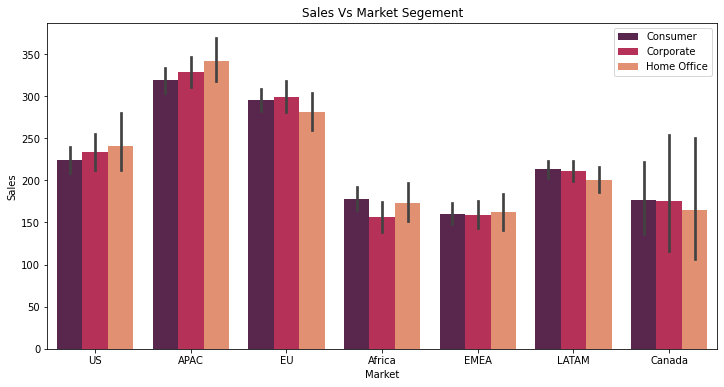

In [629]:
#Plotting the Market segments vs the Profits
plt.figure(figsize=[12,6])
sns.barplot(data=df,x='Market',y='Sales',hue='Segment',palette='rocket')
plt.title('Sales Vs Market Segement')
plt.legend(loc='best')
plt.show()

#### APAC marketis having higher Sales in all the three segments. EMEA and Africa have less sales

In [630]:
#Dropping the unneccessary columns
df.drop(['Market','Segment'],inplace=True,axis=1)
df.head()

,Order Date,Sales,Profit,Market_Segment
0,31-07-2012,2309.650,762.1845,US_Consumer
1,05-02-2013,3709.395,-288.7650,APAC_Corporate
2,17-10-2013,5175.171,919.9710,APAC_Consumer
3,28-01-2013,2892.510,-96.5400,EU_Home Office
4,05-11-2013,2832.960,311.5200,Africa_Consumer


In [631]:
#Converting the Order Date column to only Month and Year column
df['Order Date']=pd.to_datetime(df['Order Date'], format='%d-%m-%Y')
df['Order Date'] = pd.to_datetime(df['Order Date']).dt.to_period('m')
df = df.sort_values(by=['Order Date'])
df.head()

,Order Date,Sales,Profit,Market_Segment
30643,2011-01,60.9600,28.6400,LATAM_Consumer
48527,2011-01,19.3000,5.7900,US_Consumer
29861,2011-01,51.6285,4.5885,APAC_Home Office
29871,2011-01,47.9600,15.8000,LATAM_Consumer
16508,2011-01,176.6808,-156.6792,APAC_Consumer


In [632]:
#Monthwise aggregated Profits for all the 21 segments
df_profit=df.pivot_table(index=['Order Date'],values='Profit',columns='Market_Segment',aggfunc=sum)
df_profit.head()

Market_Segment,APAC_Consumer,APAC_Corporate,APAC_Home Office,Africa_Consumer,Africa_Corporate,Africa_Home Office,Canada_Consumer,Canada_Corporate,Canada_Home Office,EMEA_Consumer,...,EMEA_Home Office,EU_Consumer,EU_Corporate,EU_Home Office,LATAM_Consumer,LATAM_Corporate,LATAM_Home Office,US_Consumer,US_Corporate,US_Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,991.2825,11.5998,86.4423,475.683,219.096,856.710,3.12,5.7,NaN,-2099.364,...,116.400,-845.8290,501.9315,975.360,1976.98976,1150.88400,-106.48800,762.8067,300.9145,1383.0499
2011-02,1338.8688,4358.8254,-417.4128,1441.926,-490.551,820.302,23.31,NaN,87.99,267.060,...,216.690,-1808.1180,2988.4065,-181.041,902.37752,721.25420,300.19936,500.2865,307.2995,58.1420
2011-03,3747.1632,1213.3386,923.7492,322.140,-586.716,67.320,335.55,NaN,84.03,1598.718,...,78.972,2480.5410,736.9890,503.223,2585.17924,39.07512,285.46400,597.2773,333.0515,-431.5989
2011-04,3846.4746,71.0265,657.1080,292.122,776.691,500.136,55.08,NaN,NaN,-300.879,...,-420.090,2496.6405,1056.1785,63.858,387.72148,259.25600,-421.73440,1155.0757,1393.3828,940.3767
2011-05,3639.9423,2534.1672,-272.1717,110.004,241.338,34.926,77.97,NaN,NaN,568.302,...,262.968,254.0805,1586.2740,201.102,1002.34724,-531.74444,-240.11600,698.9171,2063.5013,-23.7088


In [633]:
df_profit.shape

(48, 21)

In [634]:
#Performing the train test split
train_len=42
train_df_profit=df_profit[:train_len]
test_df_profit=df_profit[train_len:]

In [635]:
#Calculate the CoV on the profit for each of the 21 market segments on the train data.
mean=np.mean(train_df_profit)
std=np.std(train_df_profit)
cov_df=pd.DataFrame(mean)
cov_df['std']= std
cov_df['CoV'] = std/mean
cov_df=cov_df.reset_index()
cov_df.columns= ['Market_Segment', 'Mean', 'Std', 'CoV']
cov_df.sort_values(by='CoV', ascending= True, inplace = True)
cov_df

,Market_Segment,Mean,Std,CoV
0,APAC_Consumer,4223.553586,2518.944225,0.596404
12,EU_Consumer,3627.517036,2348.762579,0.647485
15,LATAM_Consumer,2252.677529,1533.362508,0.680684
13,EU_Corporate,2251.993036,1552.403019,0.689346
1,APAC_Corporate,2556.998957,1871.535073,0.731926
16,LATAM_Corporate,1075.994223,947.154491,0.880260
19,US_Corporate,1853.568607,1904.002356,1.027209
2,APAC_Home Office,1379.120743,1446.445137,1.048817
18,US_Consumer,2603.736252,2851.858407,1.095295
14,EU_Home Office,1097.441500,1223.296718,1.114681


In [636]:
#Printing the highest and lowest values
Low=min(cov_df['CoV'].round(2))
High=max(cov_df['CoV'].round(2))
print('Low ',Low)
print('High ',High)

Low  0.6
High  6.78


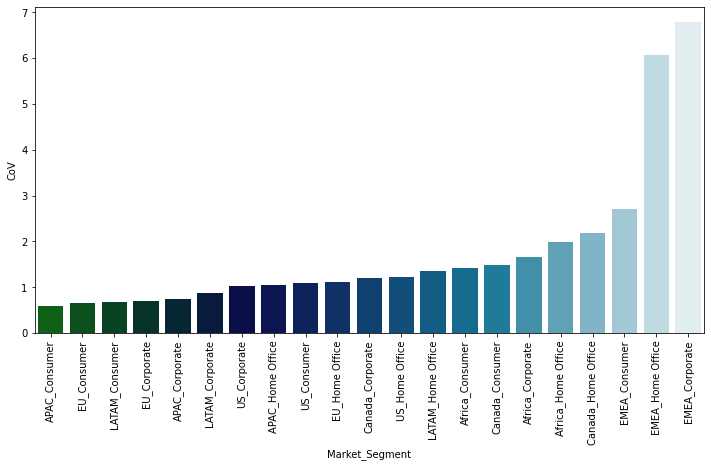

In [637]:
#VIsualizing the CoV values for different Market-Segments
plt.figure(figsize=[12,6])
sns.barplot(x='Market_Segment',y='CoV',data=cov_df,palette='ocean')
plt.xticks(rotation=90)
plt.show()

#### We can see that Lowest CoV is 0.596404. We can infer that the corresponding Marget Segment is "APAC_Consumer" ### The most profitable Market Segment is APAC_Consumer

In [638]:
#Converting the Order-Date columns from Date-Time to timestamp
df['Order Date'] = df['Order Date'].astype(str)
df['Order Date']=pd.to_datetime(df['Order Date'])

In [639]:
#Filter the dataset with the best Market-Customer Segments
#Dropping the other 20 market segemnts keep only the one with the lowest CoV
df1=df[df['Market_Segment']=='APAC_Consumer']
df1.head()

,Order Date,Sales,Profit,Market_Segment
16508,2011-01-01,176.6808,-156.6792,APAC_Consumer
24801,2011-01-01,69.3000,3.4200,APAC_Consumer
16608,2011-01-01,219.9600,8.7600,APAC_Consumer
9787,2011-01-01,337.6395,-122.8005,APAC_Consumer
29891,2011-01-01,30.4560,12.0960,APAC_Consumer


In [640]:
df1.shape

(5699, 4)

In [641]:
#Group the dataset for order date and sum of all sales month wise
data=pd.DataFrame(df1.groupby(['Order Date'])['Sales'].sum())
data.head()

,Sales
Order Date,
2011-01-01,15711.7125
2011-02-01,12910.8588
2011-03-01,19472.5632
2011-04-01,15440.3046
2011-05-01,24348.9723


In [642]:
data.shape

(48, 1)

# STEP 3: Time Series Analysis

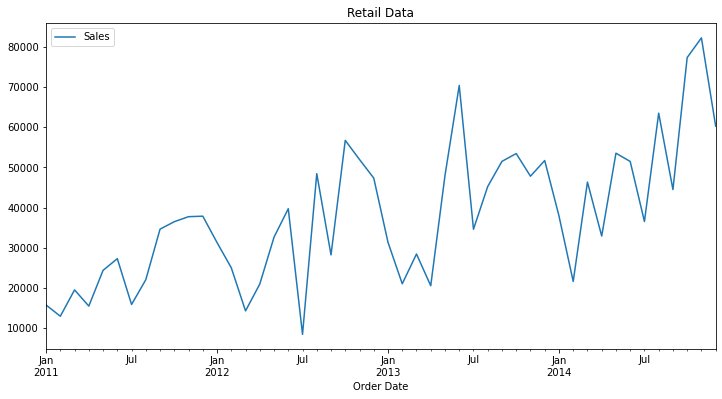

In [643]:
#Plotting the time series data
data.plot(figsize=[12,6])
plt.title('Retail Data')
plt.legend(loc='best')
plt.show()

In [644]:
#Rechecking if the data contains any missing values
data.isnull().sum()

Sales    0
dtype: int64

In [645]:
#Perform the train test split on the market segment retail data
train_len=42
train=data[0:train_len]
test=data[train_len:]

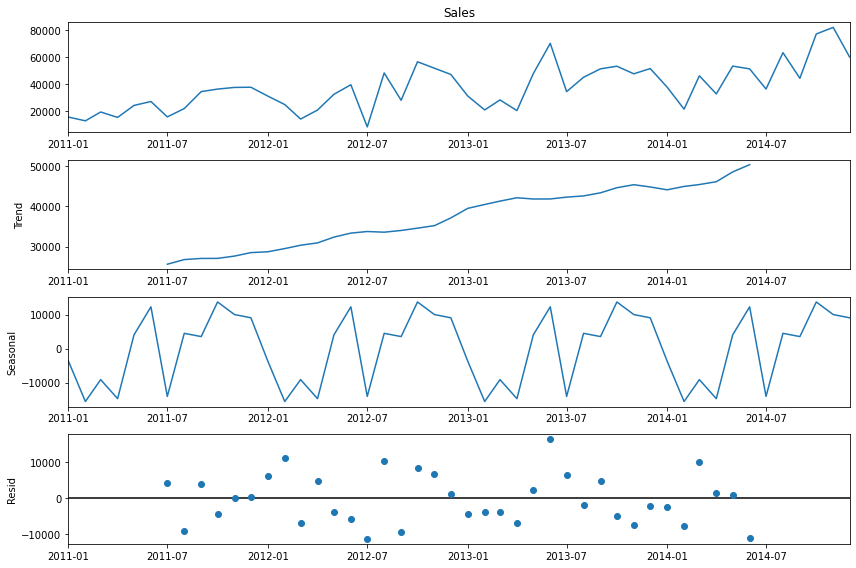

In [646]:
#Performing Additive Decompostion
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Sales,model='additive')
fig=decomposition.plot()
plt.show()

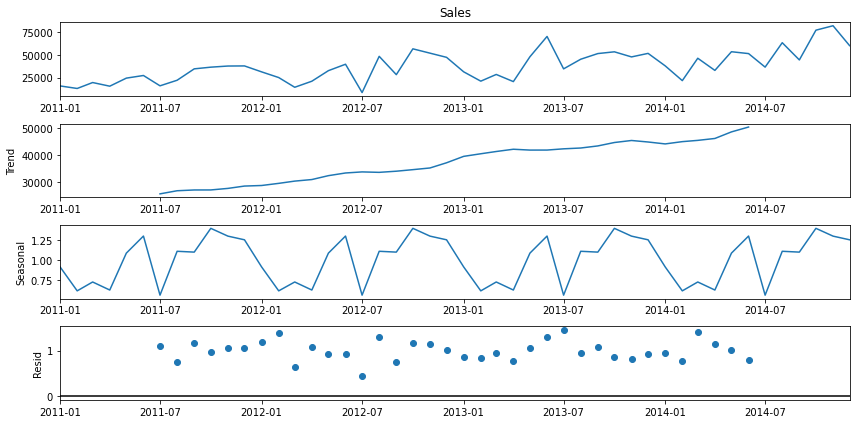

In [647]:
rcParams['figure.figsize']=12,6
decomposition=sm.tsa.seasonal_decompose(data.Sales,model='multiplicative')
fig=decomposition.plot()
plt.show()

In [648]:
#the 6 months data as the test data.
train_len = 42
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

## Simple Time Series Methods

### Naive Method

In [649]:
y_hat_naive=test.copy()
#Forecast is the last observation of the training data
y_hat_naive['naive_forecast']=train['Sales'][train_len-1]

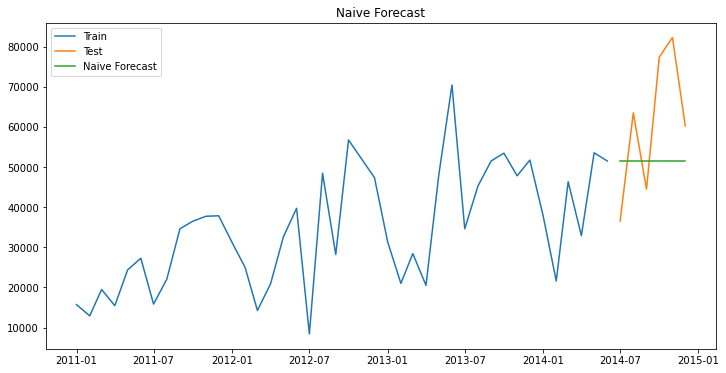

In [650]:
#Plot train, test and forecast
plt.figure(figsize=[12,6])
plt.plot(train['Sales'],label='Train')
plt.plot(test['Sales'],label='Test')
plt.plot(y_hat_naive['naive_forecast'],label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.show()

In [651]:
#Calculating the RMSE and MAPE
rmse=np.sqrt(mean_squared_error(test['Sales'],y_hat_naive['naive_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales'])*100,2)
results=pd.DataFrame({'Method':['Naive Method'],'RMSE':[rmse],'MAPE':[mape]})
results=results[['Method','RMSE','MAPE']]
results

,Method,RMSE,MAPE
0,Naive Method,18774.05,26.86


### Simple Average Method

In [652]:
y_hat_avg=test.copy()
#Finding the simple mean of the entire sales data
y_hat_avg['avg_forecast']=train['Sales'].mean()

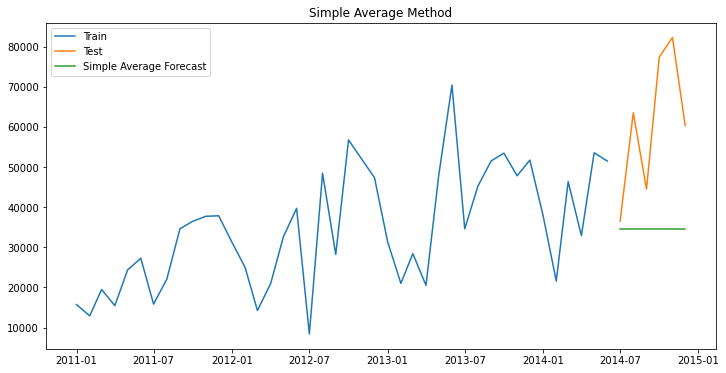

In [653]:
# Plot train, test and forecast
plt.figure(figsize=[12,6])
plt.plot(train['Sales'],label='Train')
plt.plot(test['Sales'],label='Test')
plt.plot(y_hat_avg['avg_forecast'],label='Simple Average Forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [654]:
#Calculating the RMSE and MAPE
rmse=np.sqrt(mean_squared_error(test['Sales'],y_hat_avg['avg_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Sales']-y_hat_avg['avg_forecast'])/test['Sales'])*100,2)
tempResults=pd.DataFrame({'Method':['Simple Average Method'],'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([tempResults,results])
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86


#### Forecast of months from 2014-07 to 2015-01 = Average of all past months’ sales
#### Green line is the average of all the 42 months sales data
#### The green line we forecasted is not showing any trend or seasonality while our train and test data had both trend and seasonality

### Simple Moving Average Method

In [655]:
#3 Month Window
#Reduces unsystematic noise in the data
y_hat_sma=data.copy()
ma_window=3
y_hat_sma['sma_forecast']=data['Sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:]=data['Sales'][train_len-1]

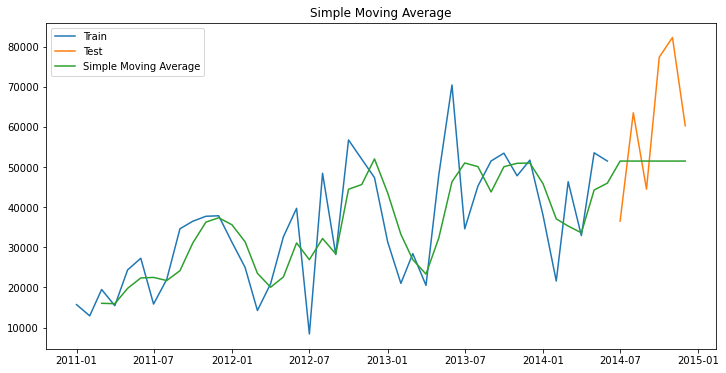

In [656]:
#Plot train, test and forecast
plt.figure(figsize=[12,6])
plt.plot(train['Sales'],label='Train')
plt.plot(test['Sales'],label='Test')
plt.plot(y_hat_sma['sma_forecast'],label='Simple Moving Average')
plt.legend(loc='best')
plt.title('Simple Moving Average')
plt.show()

In [657]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sma['sma_forecast'][train_len:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86


## Exponential Smoothing Methods
### Simple Exponential Method

In [658]:
#The simple exponetial model captures the level of a time series.
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6)

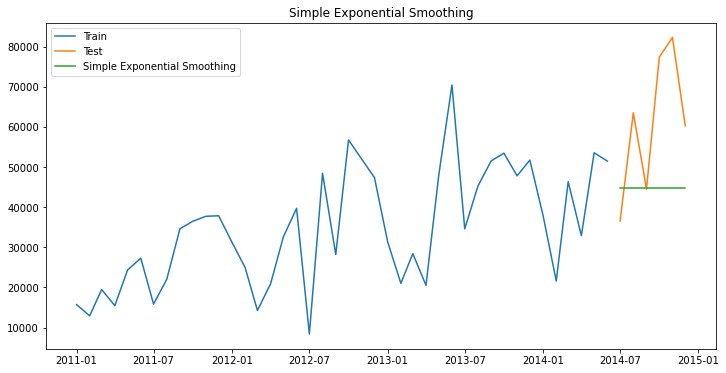

In [659]:
#Plot train, test, forecast
plt.figure(figsize=[12,6])
plt.plot(train['Sales'],label='Train')
plt.plot(test['Sales'],label='Test')
plt.plot(y_hat_ses['ses_forecast'],label='Simple Exponential Smoothing')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing')
plt.show()

In [660]:
#Calculating the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)
results1 = pd.DataFrame({'Method':['Simple Exponential Smoothing'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, results1])
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70


### Holt's Exponential Smoothing

In [661]:
#Captures both level and trend of a time series in the forecast
model=ExponentialSmoothing(np.asarray(data['Sales']),seasonal_periods=12,trend='additive',seasonal=None)
model_fit=model.fit(optimized=True)
print(model_fit.params)
y_hat_holt=test.copy()
y_hat_holt['holt_forecast']=model_fit.forecast(6)

{'smoothing_level': 0.4057142857142857, 'smoothing_trend': 0.07513227513227512, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 15711.712500000001, 'initial_trend': -2800.8537000000033, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


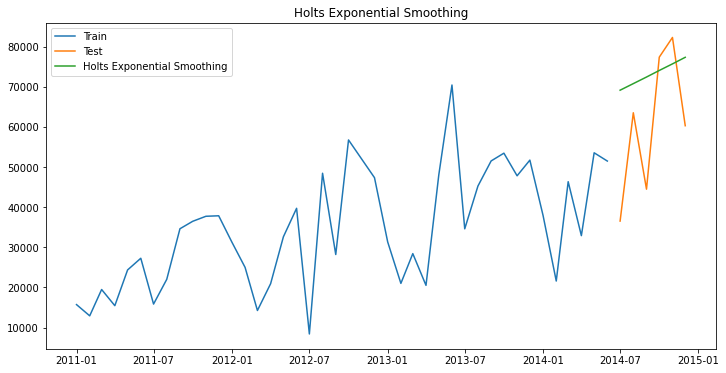

In [662]:
#Plot train, test and forecast
plt.figure(figsize=[12,6])
plt.plot(train['Sales'],label='Train')
plt.plot(test['Sales'],label='Test')
plt.plot(y_hat_holt['holt_forecast'],label='Holts Exponential Smoothing')
plt.legend(loc='best')
plt.title('Holts Exponential Smoothing')
plt.show()

In [663]:
#Calculate the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)
results1 = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results= pd.concat([results, results1])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70
0,Holt's exponential smoothing method,19334.39,34.02


#### We can see that the forecast is a straight line, sloping upwards as Holt's method captured both level and trend

### Holt Winters Exponential Smoothing (Additive)

In [664]:
#Forecasts based on level, trend and seasonality of a time series
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.040357142857142855, 'smoothing_trend': 0.040357142857142855, 'smoothing_seasonal': 0.13709183673469388, 'damping_trend': nan, 'initial_level': 29061.291899999997, 'initial_trend': 730.4167145833331, 'initial_seasons': array([-13349.5794, -16150.4331,  -9588.7287, -13620.9873,  -4712.3196,
        -1801.2723, -13218.4602,  -7049.0553,   5551.893 ,   7410.7551,
         8661.312 ,   8785.6992]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


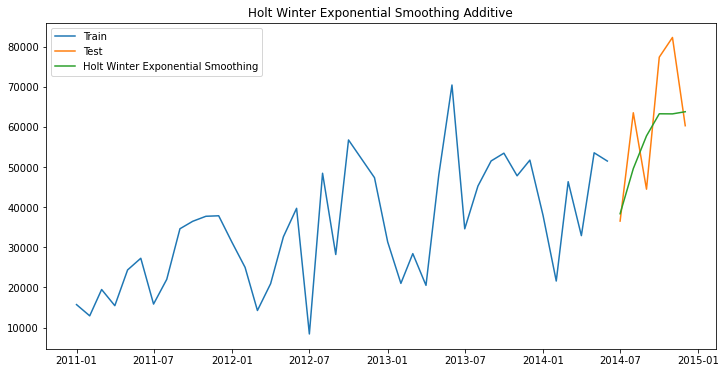

In [665]:
#Plot train, test and forecast
plt.figure(figsize=[12,6])
plt.plot(train['Sales'],label='Train')
plt.plot(test['Sales'],label='Test')
plt.plot(y_hat_hwa['hw_forecast'],label='Holt Winter Exponential Smoothing')
plt.legend(loc='best')
plt.title('Holt Winter Exponential Smoothing Additive')
plt.show()

In [666]:
#Calculate the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' Additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70
0,Holt's exponential smoothing method,19334.39,34.02
0,Holt Winters' Additive method,12565.60,17.32


### Holt Winters Exponential Smoothing Method (Multiplicative)

In [667]:
#Forecasts based on level, trend and seasonality of a time series
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.005, 'smoothing_trend': 0.005, 'smoothing_seasonal': 0.3198214285714286, 'damping_trend': nan, 'initial_level': 29061.291899999997, 'initial_trend': 730.4167145833331, 'initial_seasons': array([0.54064054, 0.44426307, 0.67005153, 0.53130138, 0.83784893,
       0.93801816, 0.54515235, 0.75744178, 1.19104082, 1.25500432,
       1.29803603, 1.3023162 ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


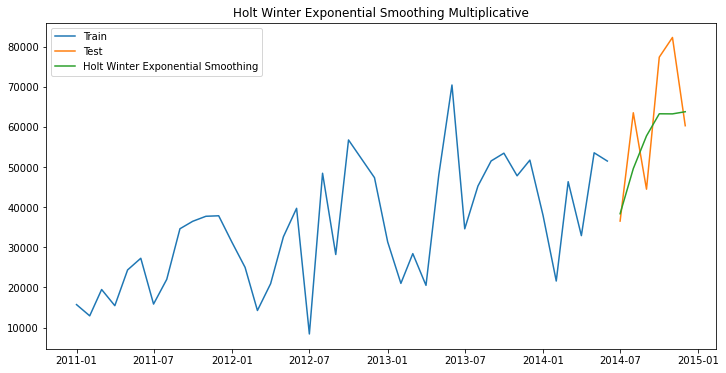

In [668]:
#Plot train, test and forecast
plt.figure(figsize=[12,6])
plt.plot(train['Sales'],label='Train')
plt.plot(test['Sales'],label='Test')
plt.plot(y_hat_hwa['hw_forecast'],label='Holt Winter Exponential Smoothing')
plt.legend(loc='best')
plt.title('Holt Winter Exponential Smoothing Multiplicative')
plt.show()

In [669]:
#Calculate the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70
0,Holt's exponential smoothing method,19334.39,34.02
0,Holt Winters' Additive method,12565.60,17.32
0,Holt Winters' Multiplicative method,10876.35,18.27


#### We can see Holt Winter's Additive method has the lowest RMSE and MAPE values. Which means error measures are very less in this model

#### From the Smoothing Techniques performed we can conclude that Holt Winter's Additive Method is giving the better forecast to of the sales for the 6 months, since the predicted sales are closer to the actual sales.
#### We could also see that the RMSE and MAPE values is the least among all the methods done above.

## Auto Regressive Methods

### Stationarity vs non-stationary time series

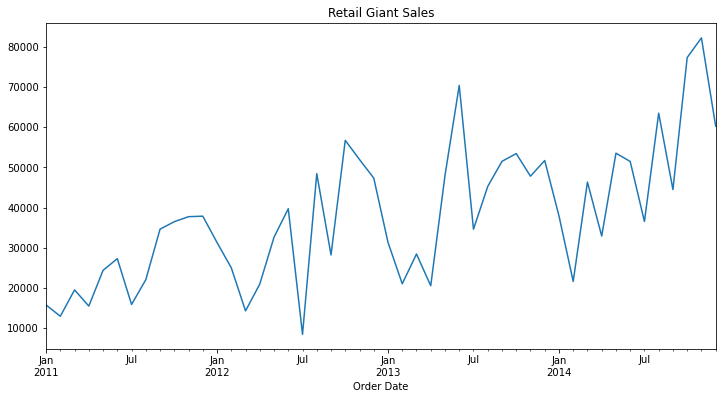

In [670]:
data['Sales'].plot(figsize=[12,6])
plt.title('Retail Giant Sales')
plt.show()

### Augmented Dickey-Fuller (ADF) test

In [671]:
adf_test=adfuller(data['Sales'])
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.220857
Critical Values @ 0.05: -2.93
p-value: 0.198763


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [672]:
kpss_test=kpss(data['Sales'])
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.595515
Critical Values @ 0.05: 0.46
p-value: 0.023044


### Box Cox transformation to make variance constant

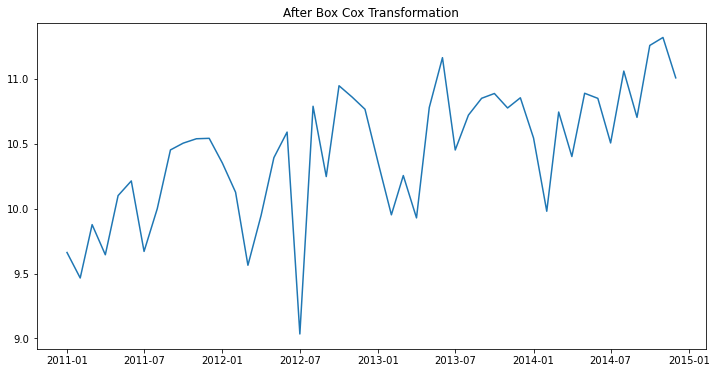

In [673]:
data_boxcox=pd.Series(boxcox(data['Sales'],lmbda=0),index=data.index)
plt.figure(figsize=[12,6])
plt.plot(data_boxcox,label='After BOXCOX transformation')
plt.title('After Box Cox Transformation')
plt.show()

#### Box-Cox Transformation makes the variance constant in a Time series.

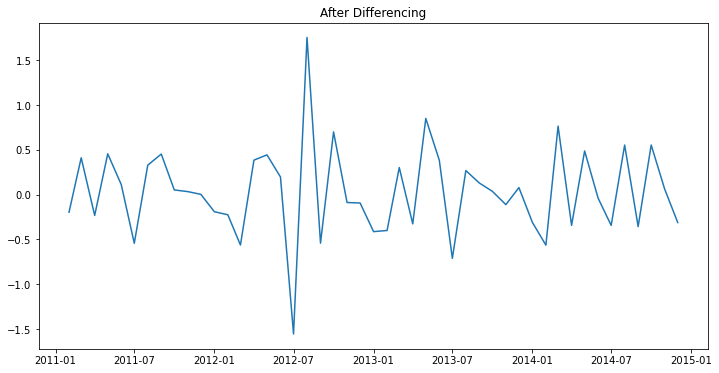

In [674]:
data_boxcox_diff=pd.Series(data_boxcox-data_boxcox.shift(),data.index)
plt.figure(figsize=[12,6])
plt.plot(data_boxcox_diff,label='After Differencing')
plt.title('After Differencing')
plt.show()

#### Differencing to remove the trend and seasonality 

In [675]:
#Removing the first value
data_boxcox_diff.dropna(inplace=True)

### Augmented Dickey-Fuller (ADF) test (After Box Cox and Differencing)

In [676]:
adf_test=adfuller(data_boxcox_diff)
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.769275
Critical Values @ 0.05: -2.95
p-value: 0.000001


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test (After Box Cox and Differencing)

In [677]:
kpss_test=kpss(data_boxcox_diff)
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.135659
Critical Values @ 0.05: 0.46
p-value: 0.100000


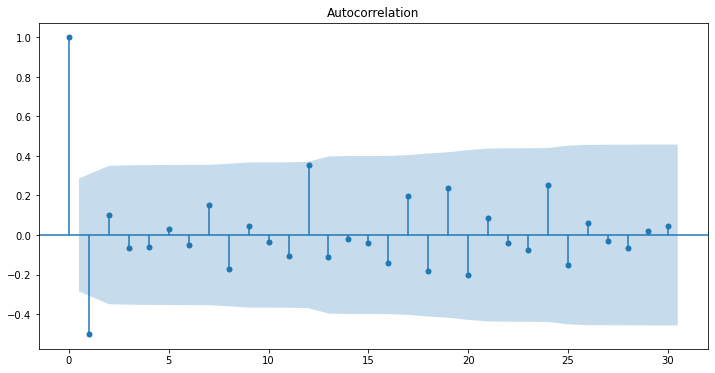

In [678]:
plt.figure(figsize=(12,6))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

#### ACF describes the autocorrelation between observation and another observation at a prior time step that includes direct and indirect dependence information.

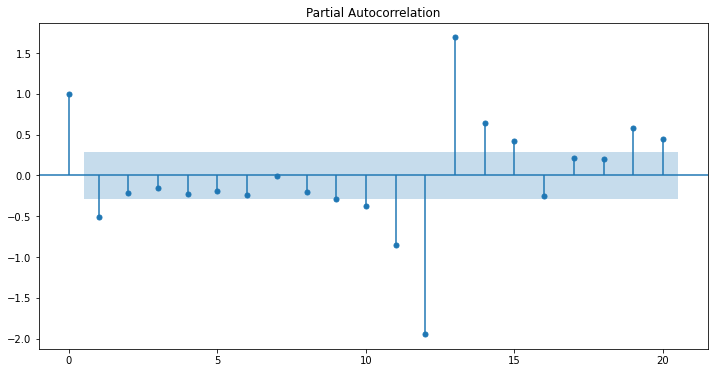

In [679]:
plt.figure(figsize=(12,6))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 20)
plt.show()

#### The PACF only describes the direct relationship between an observation and its lag.

In [680]:
train_boxcox = data_boxcox[:train_len]
test_boxcox = data_boxcox[train_len:]
train_boxcox_diff = data_boxcox_diff[:train_len-1]
test_boxcox_diff = data_boxcox_diff[train_len-1:]

### Auto Regression Model (AR)

In [681]:
model = ARIMA(train_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.031320
ar.L1.y   -0.483978
dtype: float64


In [682]:
#Recover the orignal time series
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

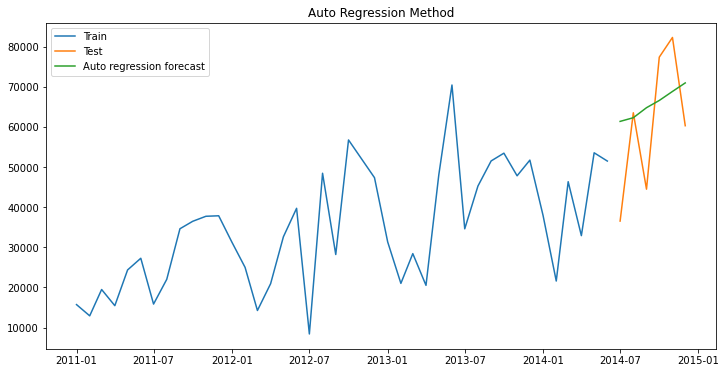

In [683]:
#Plot train, test and forecast
plt.figure(figsize=(12,6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [684]:
#Calculate the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70
0,Holt's exponential smoothing method,19334.39,34.02
0,Holt Winters' Additive method,12565.60,17.32
0,Holt Winters' Multiplicative method,10876.35,18.27
0,Autoregressive (AR) method,15505.02,27.27


#### From the plot we can see that we are able to capture trend in the forecast but could not cature the seasonality


### Moving Average Model

#### The Moving Average Model models the future forecasts using past forecast errors in a regression-like model.

In [685]:
model=ARIMA(train_boxcox_diff,order=(0,0,1))
model_fit=model.fit()
print(model_fit.params)
y_hat_ma=data_boxcox_diff.copy()

const      0.022694
ma.L1.y   -1.000000
dtype: float64


In [686]:
#Recorvering the time series
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

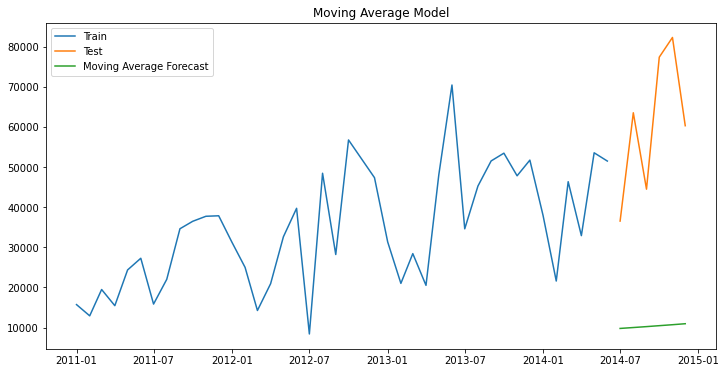

In [687]:
#Plot train, test and forecast
plt.figure(figsize=[12,6])
plt.plot(train['Sales'],label='Train')
plt.plot(test['Sales'],label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():],label='Moving Average Forecast')
plt.legend(loc='best')
plt.title('Moving Average Model')
plt.show()

In [688]:
#Calculate the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ma['ma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][train_len-1:])/test['Sales'])*100,2)
results1 = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, results1])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70
0,Holt's exponential smoothing method,19334.39,34.02
0,Holt Winters' Additive method,12565.60,17.32
0,Holt Winters' Multiplicative method,10876.35,18.27
0,Autoregressive (AR) method,15505.02,27.27
0,Moving Average (MA) method,52903.35,81.64


#### The RMSE and MAPE values are high which means too many errors

### Auto Regressive Moving Average Model (ARMA) Model

#### A time series that exhibits the characteristics of an  AR(p)  and/or  MA(q)  process can be modelled using an  ARMA(p,q)  model

In [689]:
model = ARIMA(train_boxcox_diff, order=(1, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.022810
ar.L1.y    0.115922
ma.L1.y   -0.999939
dtype: float64


In [690]:
#Recover the time series 
y_hat_arma=data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff']=model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox']=y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox']=y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast']=np.exp(y_hat_arma['arma_forecast_boxcox'])

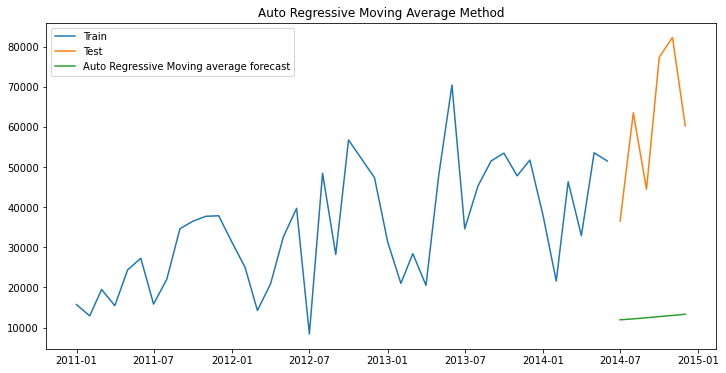

In [702]:
#Plot train, test and forecast
plt.figure(figsize=(12,6))
plt.plot(data['Sales'][:train_len], label='Train')
plt.plot(data['Sales'][train_len:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='Auto Regressive Moving average forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Moving Average Method')
plt.show()

In [692]:
#Calculate the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70
0,Holt's exponential smoothing method,19334.39,34.02
0,Holt Winters' Additive method,12565.60,17.32
0,Holt Winters' Multiplicative method,10876.35,18.27
0,Autoregressive (AR) method,15505.02,27.27
0,Moving Average (MA) method,52903.35,81.64
0,Autoregressive moving average (ARMA) method,50757.91,77.66


#### ARMA model captured Trend and errors but no seasonality

### Auto regressive integrated moving average (ARIMA)

#### ARIMA model has three parameters p: Highest lag included in the regression model, d: Degree of differencing to make the series stationary, q: Number of past error terms included in the regression model

In [693]:
model=ARIMA(train_boxcox,order=(1,1,1))
model_fit=model.fit()
print(model_fit.params)
y_hat_arima=test.copy()

const        0.022810
ar.L1.D.y    0.115922
ma.L1.D.y   -0.999939
dtype: float64


In [694]:
#Recover the time series 
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

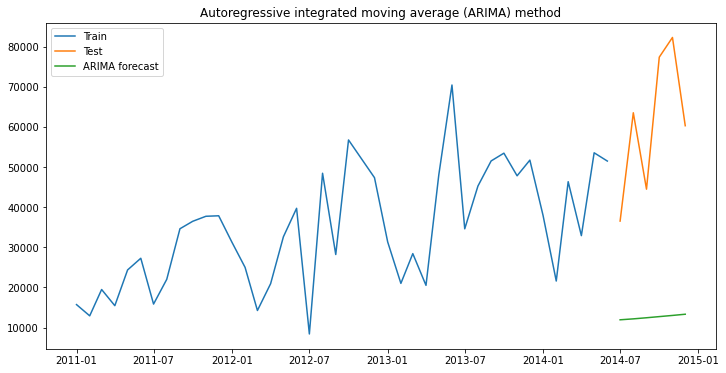

In [703]:
#Plot train, test and forecast
plt.figure(figsize=(12,6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [696]:
#Calculate the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70
0,Holt's exponential smoothing method,19334.39,34.02
0,Holt Winters' Additive method,12565.60,17.32
0,Holt Winters' Multiplicative method,10876.35,18.27
0,Autoregressive (AR) method,15505.02,27.27
0,Moving Average (MA) method,52903.35,81.64
0,Autoregressive moving average (ARMA) method,50757.91,77.66


### Seasonal auto regressive integrated moving average (SARIMA)

#### SARIMA brings all the features of an ARIMA model with an extra feature - seasonality. SARIMA has six parameters along with seasonality.

In [697]:
model = SARIMAX(train_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.100114
ma.L1      -0.995772
ar.S.L12   -0.395173
ma.S.L12   -0.989192
sigma2      0.047113
dtype: float64


In [698]:
#Recover the time series 
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

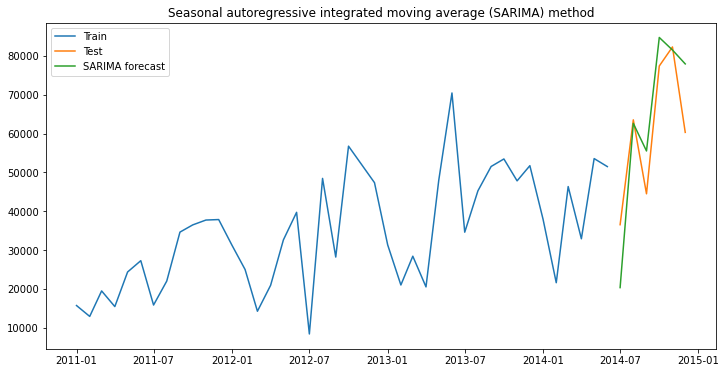

In [704]:
#Plot train, test and forecast
plt.figure(figsize=(12,6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [700]:
#Calculate the RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['(SARIMA) Seasonal autoregressive integrated moving average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average Method,30846.00,38.18
0,Naive Method,18774.05,26.86
0,Simple moving average forecast,18774.05,26.86
0,Simple Exponential Smoothing,22824.62,27.70
0,Holt's exponential smoothing method,19334.39,34.02
0,Holt Winters' Additive method,12565.60,17.32
0,Holt Winters' Multiplicative method,10876.35,18.27
0,Autoregressive (AR) method,15505.02,27.27
0,Moving Average (MA) method,52903.35,81.64
0,Autoregressive moving average (ARMA) method,50757.91,77.66


#### The forecast captured both trend and seasonality. SARIMA method is able to predict the sales closer to the actual values
